#UC Irvine Multiple Features of Handwritten Numerals: Dimensionality Reduction, Unsupervised Learning, & A Pretrained ResNet Model

Clayton Greenwell

Resources used to complete this assignment:
- Stack Overflow
- Aurélien Geron's Github code that follows the class textbook "Hands On Machine Learning"
- Code from class powerpoint slides
- UC Irvine's dataset has a ReadMe file (mfeat.info) where I've derived most of the information about the dataset

**Tip For Running Notebook**

If you are using Google Colab, make sure to select a GPU (even if you're not using a GPU via Edit->Notebook settings, it will give you more memory).


In [1]:
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

**Project Goal and Introduction**

The goal of this project is to gain practical programming experience with dimensionality reduction, unsupervised learning, and ResNet models. This project will include PCA, K-means clustering, and EM (expectation-maximization). This project will make use of scikit-learn and PyTorch.

**UC Irvine "Multiple Features" Digit dataset:** https://archive.ics.uci.edu/dataset/72/multiple+features

This dataset consists of features of handwritten numerals (0 through 9) extracted from a collection of Dutch utility maps. 200 patterns per class (for a total of 2,000 patterns) have been digitized in  binary images. These digits are represented in terms of the following 6 feature sets (files):

1. mfeat-fou: 76 Fourier coefficients of the character shapes;
2. mfeat-fac: 216 profile correlations;
3. mfeat-kar: 64 Karhunen-Loeve coefficients;
4. mfeat-pix: 240 pixel averages in 2 x 3 windows;
5. mfeat-zer: 47 Zernike moments;
6. mfeat-mor: 6 morphological features.

I am choosing to not use "morphological features" attribute in this analysis.

**Aside from Pixel, all feature sets (attributes) contain compressed metadata that numerically represent properties about the written image, not the image itself.**

A quick way to understand the 5 attributes we are using:

- **Fourier = shape outline:** the handwritten number is transformed via Fourier Transformation into a set of coefficients that describe the shape’s outline in terms of sinusoidal/frequency components. These *compact* coefficients capture the overall shape structure.
- **Profile = shape distribution** profile-based features. Projections of intensity and boundary profiles of the written number. Captures structural information about how the digit’s shape distributes across different directions and/or slices. Similarities with Pixel.
- **Karhunen-Loeve = global variation patterns:** a statistical projection of the written image onto a lower-dimensional basis obtained via the Karhunen–Loeve transform. Captures the major modes of variation across the dataset. Describes each written digit in terms of the principal modes.
- **Pixel = density and stroke distribution:** down-sampling style representation. The binary image is partitioned into a 2×3 window grid, and within each small window the average pixel value (or density) is computed. This yields 240 numbers. This captures coarse spatial distribution of strokes / pixels but loses fine shape details.
- **Zernike = global shape properties:** image moments computed using an orthogonal basis of Zernike polynomials (defined over a disk).

In each file the 2000 patterns are stored in ASCI on 2000 lines. The first 200 patterns are of class 0, followed by sets of 200 patterns for each of the classes (and so on, 1 to 9).

Notes from UC Irvine say that the source image dataset has been lost. **Using the pixel-dataset, (mfeat-pix) sampled versions of the original images can be obtained.**

There are no missing values.

In [2]:
# These 2 code cells will allow you to download the UC Irvine dataset
# and store locally in Google Colab.
# Remember, we don't care about the morphological features attribute.

base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/"
os.makedirs("mfeat", exist_ok=True)

mfeat_files = {
    "fou": "mfeat-fou",   # Fourier coefficients of the character shapes
    "fac": "mfeat-fac",   # Profile correlations
    "kar": "mfeat-kar",   # Karhunen-Loeve coefficients
    "pix": "mfeat-pix",   # 16x15 pixel averages (we'll treat these like 'images')
    "zer": "mfeat-zer",   # Zernike moments
}

In [3]:
for key, fname in mfeat_files.items():
    local_path = os.path.join("mfeat", fname)
    if not os.path.exists(local_path):
        try:
            print(f"Downloaded {fname}!")
            urllib.request.urlretrieve(base_url + fname, local_path)
        except Exception as e:
            print(f"Couldn't download {fname}: {e}")
    else:
        print(f"Found existing {fname}")

Downloaded mfeat-fou!
Downloaded mfeat-fac!
Downloaded mfeat-kar!
Downloaded mfeat-pix!
Downloaded mfeat-zer!


I want to put our 5 attributes (feature sets) into NumPy arrays. This will make them easier to work with throughout this project.

In [4]:
def load_mfeat_view(path):
    return np.loadtxt(path)

mfeat_fou = load_mfeat_view(os.path.join("mfeat", "mfeat-fou"))
mfeat_fac = load_mfeat_view(os.path.join("mfeat", "mfeat-fac"))
mfeat_kar = load_mfeat_view(os.path.join("mfeat", "mfeat-kar"))
mfeat_pix = load_mfeat_view(os.path.join("mfeat", "mfeat-pix"))
mfeat_zer = load_mfeat_view(os.path.join("mfeat", "mfeat-zer"))

print("Attribute (feature set) shapes:")
print("Fourier  (fou):", mfeat_fou.shape)
print("Profile  (fac):", mfeat_fac.shape)
print("Karhunen-Loeve  (kar):", mfeat_kar.shape)
print("Pixels  (pix):", mfeat_pix.shape)
print("Zernike (zer):", mfeat_zer.shape)

Attribute (feature set) shapes:
Fourier  (fou): (2000, 76)
Profile  (fac): (2000, 216)
Karhunen-Loeve  (kar): (2000, 64)
Pixels  (pix): (2000, 240)
Zernike (zer): (2000, 47)


In [5]:
# There are 10 digit classes (0–9), with 200 samples per class.
labels = np.repeat(np.arange(10), 200)

fou_labels = labels.copy()
fac_labels = labels.copy()
kar_labels = labels.copy()
pix_labels = labels.copy()
zer_labels = labels.copy()

print("Shapes by attribute:")
for name, data in [
    ("Fourier", mfeat_fou),
    ("Profile", mfeat_fac),
    ("Karhunen-Loeve", mfeat_kar),
    ("Pixels", mfeat_pix),
    ("Zernike", mfeat_zer),
]:
    print(f"{name:10s}: {data.shape}, labels: {labels.shape}")

Shapes by attribute:
Fourier   : (2000, 76), labels: (2000,)
Profile   : (2000, 216), labels: (2000,)
Karhunen-Loeve: (2000, 64), labels: (2000,)
Pixels    : (2000, 240), labels: (2000,)
Zernike   : (2000, 47), labels: (2000,)


# 1. Apply PCA to Images

Apply PCA to the images from different conditions.  How many components do you need to preserve at least 95% of the variance in each condition? Why do some conditions require more components than others?



In [6]:
print(
    len(mfeat_fou),
    len(mfeat_fac),
    len(mfeat_kar),
    len(mfeat_pix),
    len(mfeat_zer)
)

2000 2000 2000 2000 2000


To start, we're applying a standardization technique to the dataset to turn a 1D feature vector into a squar 2D array for visualization.

In [7]:
def vector_to_image(arr):
    arr = np.asarray(arr)
    n_features = arr.shape[0]
    h = int(np.floor(np.sqrt(n_features)))
    if h < 1:
        h = 1

    w = int(np.ceil(n_features / h))
    total = h * w
    padded = np.zeros(total, dtype=float)
    length = min(total, n_features)
    padded[:length] = arr[:length]
    return padded.reshape(h, w)

Now, we can get to work on finding the number of components needed to preserve 95% of our variance for each image type. We can fit each preprocessed image set on PCA, look at the explained_variance_ratio_ stat, and then use the cumsum() function to incrementally add each component's explained variance to a total. When that total passes 95%, we add one final component and return the value.

In [8]:
from sklearn.decomposition import PCA

def pca_components_for_95(data):
    pca = PCA()

    # Fit PCA on the image data (data must be num_images × num_pixels)
    pca.fit(data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Find the smallest number of components needed to reach 95% variance
    # np.argmax returns the first index where the condition is True
    comps = np.argmax(cumsum >= 0.95) + 1

    return comps

In [9]:
print("Fourier:", pca_components_for_95(mfeat_fou))
print("Profile:", pca_components_for_95(mfeat_fac))
print("Karhunen-Loeve:", pca_components_for_95(mfeat_kar))
print("Pixels:", pca_components_for_95(mfeat_pix))
print("Zernike:", pca_components_for_95(mfeat_zer))

Fourier: 50
Profile: 12
Karhunen-Loeve: 36
Pixels: 88
Zernike: 13


To preserve at least 95% of the variance, Profile and Zernike attributes required around 12 to 13 components, while Pixels, Fourier, and Karhunen-Loeve attributes needed a wider range of 35 to 90 components.

The difference seems to come from the complexity of the attributes. Because we're actually able to reconstruct images using the Pixels attribute, it would make perfect sense for this to require the most components. Profile and Zernike using significantly less components would make sense, as both are more concerned with capturing a compact representation of shape.

This next part isn't strictly necessary, but we can get a better idea of what each principal component's contribution looks like for each image type through plotting. Below, we do it for the Pixel attribute, but it can be done for any feature set that had PCA performed on it as a unit. The left plot (a "scree plot") shows each individual component's explained variance on its own, and the right plot shows the cumulative sum of all components up to that point, as well as a threshold line at 95% explained variance. We can use these plots to get a better idea of where component contribution starts to taper off.

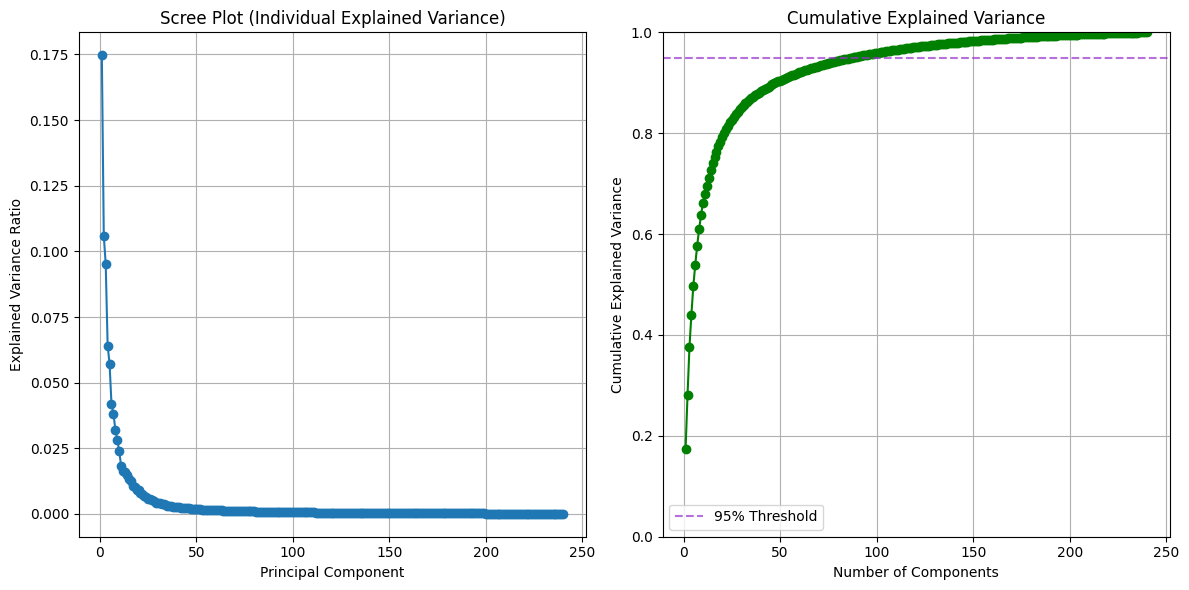

In [10]:
from sklearn.decomposition import PCA

# Fit PCA on pixel attribute
pca_pix = PCA()
pca_pix.fit(mfeat_pix)

# Explained variance ratio for each component
explained_variance_ratio = pca_pix.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting
plt.figure(figsize=(12, 6))

# Scree plot: individual explained variance per component
plt.subplot(1, 2, 1)

plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o'
)

plt.title('Scree Plot (Individual Explained Variance)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

# Cumulative explained variance
plt.subplot(1, 2, 2)

plt.plot(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    color='green'
)

plt.axhline(
    y=0.95,
    color='darkorchid',
    linestyle='--',
    alpha = 0.7,
    label='95% Threshold'
)

plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

An elbow-like bend is observed within the first ~40 to 90 components in the cumulative explained variance graph, suggesting that after this point, additional components contribute increasingly less variance. This serves as another piece of evidence that our optimal number of components is somewhere within this range.

# 2. Plot 10 Images

Plot 10 realistic images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept at least 95% of the variance using PCA.

In [11]:
# Fit PCA on pixel attribute
pca_pix = PCA()
pca_pix.fit(mfeat_pix)

# Find number of components to preserve at least 95% variance
cumsum = np.cumsum(pca_pix.explained_variance_ratio_)
components_95 = np.argmax(cumsum >= 0.95) + 1
print("Components needed for 95% variance:", components_95)

Components needed for 95% variance: 88


In [12]:
# Keep only the top components that preserve ~95% variance
pca_pix_95 = PCA(n_components=components_95)
pix_projected = pca_pix_95.fit_transform(mfeat_pix)
pix_reconstructed = pca_pix_95.inverse_transform(pix_projected)

print('Projected shape:', pix_projected.shape)
print('Reconstructed shape:', pix_reconstructed.shape)

Projected shape: (2000, 88)
Reconstructed shape: (2000, 240)


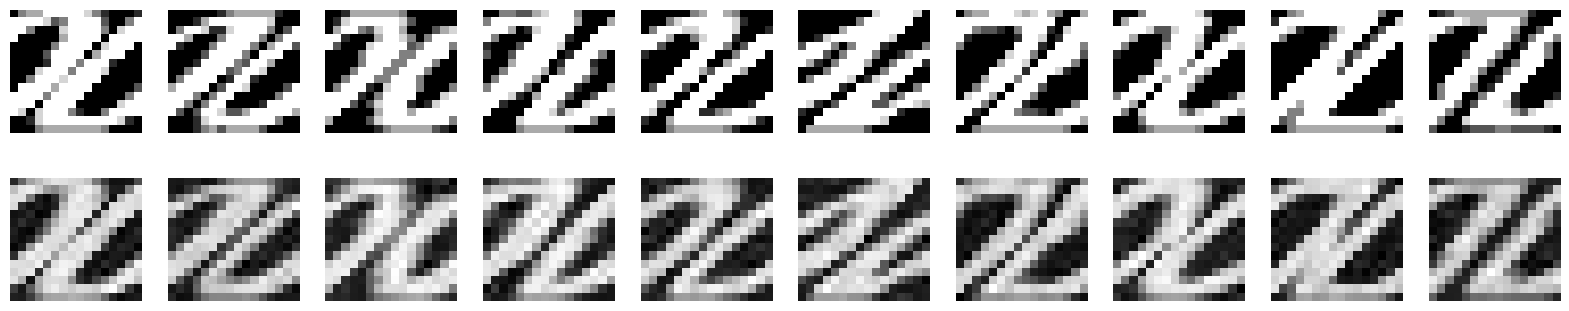

In [13]:
# Choose 10 samples (first 10 for simplicity)
n_images = 10
fig, axes = plt.subplots(2, n_images, figsize=(20, 4))

for i in range(n_images):
    # Original
    orig_img = vector_to_image(mfeat_pix[i])
    axes[0, i].imshow(orig_img, cmap='gray')
    axes[0, i].axis('off')

    # Reconstructed
    recon_img = vector_to_image(pix_reconstructed[i])
    axes[1, i].imshow(recon_img, cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
plt.show()

All pixel images are well-preserved and easily distinguishable. That's a good sign for if we were to scale up this process and try working with many more images. That said, removal of some variance via PCA did introduce clear noise to each image, which is especially noticeable in their formerly-white backgrounds.

# 3. A) Reducing Dimensionality to Only 2 Dimensions using PCA

Each of the images belongs to 1 of 10 clusters (0 through 9). We will now try to see if the visualization can help us identify different clusters.

For each condition (attribute), use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components for each condition?

>This can be done using a new PCA function with the n_components parameter set to 2. In the explain_variance() function below, we do exactly that, then project it onto the data, and then use the explained_variance_ratio_ feature like before to find the two first PCs' explained variance. For convenience, this is output as a table containing information on each image condition's first component EV, second component EV, and combined EV.

>Before that, though, we also scale our data via standardization. This seems to be highly recommended for PCA in general, specifically because it can help deal with disparate variable ranges as usual.

In [14]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

scaler = StandardScaler()

# scale all the folders
fou_scaled = scaler.fit_transform(mfeat_fou)
fac_scaled = scaler.fit_transform(mfeat_fac)
kar_scaled = scaler.fit_transform(mfeat_kar)
pix_scaled = scaler.fit_transform(mfeat_pix)
zer_scaled = scaler.fit_transform(mfeat_zer)

def explain_variance(data, n_components = 2):
  # Define the dimensions
  _2_dim_pca = PCA(n_components)

  # Perform PCA
  data_projected = _2_dim_pca.fit(data)

  # Explained variances
  explained_variance = _2_dim_pca.explained_variance_ratio_

  return explained_variance

# Calculate explained variance for each condition
conditions = ['Fourier', 'Profile', 'Karhunen-Loeve', 'Pixels', 'Zernike']
headers = ["Conditions", "PC 1", "PC 2", "Combined PCs"]
datasets = [fou_scaled,
            fac_scaled,
            kar_scaled,
            pix_scaled,
            zer_scaled
]

variance_data = []
for condition, data in zip(conditions, datasets):
    variance = explain_variance(data)
    variance_data.append([condition, variance[0], variance[1], sum(variance)])

print(tabulate(variance_data, headers = headers,  tablefmt="grid"))

+----------------+-----------+-----------+----------------+
| Conditions     |      PC 1 |      PC 2 |   Combined PCs |
+================+===========+===========+================+
| Fourier        | 0.156203  | 0.0682685 |       0.224472 |
+----------------+-----------+-----------+----------------+
| Profile        | 0.224992  | 0.151251  |       0.376243 |
+----------------+-----------+-----------+----------------+
| Karhunen-Loeve | 0.0914997 | 0.0800431 |       0.171543 |
+----------------+-----------+-----------+----------------+
| Pixels         | 0.161297  | 0.0976424 |       0.25894  |
+----------------+-----------+-----------+----------------+
| Zernike        | 0.26022   | 0.186063  |       0.446284 |
+----------------+-----------+-----------+----------------+


There's some variability in how much variance is explained by the first two PCs for each condition. Zernike gets the most at nearly 45%, followed by Profile at around 38%. Karhunen-Loeve has by far the lowest at just over 17%. In general, it seems like we can explain more variance with fewer principal components for digit images that are less complex and have fewer distinct visual parts to keep track of.

#3. B) Scatter Plots

Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image class (so you will have 10 different colors). Repeat the process and create the same type of plots for t-SNE, LLE and UMAP.

In [15]:
import warnings
warnings.filterwarnings("ignore")

Fourier: 2000 samples, 10 unique labels
Profile: 2000 samples, 10 unique labels
Karhunen-Loeve: 2000 samples, 10 unique labels
Pixels: 2000 samples, 10 unique labels
Zernike: 2000 samples, 10 unique labels

Fourier: 2000 samples
Running PCA for Fourier...
Running t-SNE for Fourier (perplexity=30)...
Running LLE for Fourier (n_neighbors=10)...
Running UMAP for Fourier...


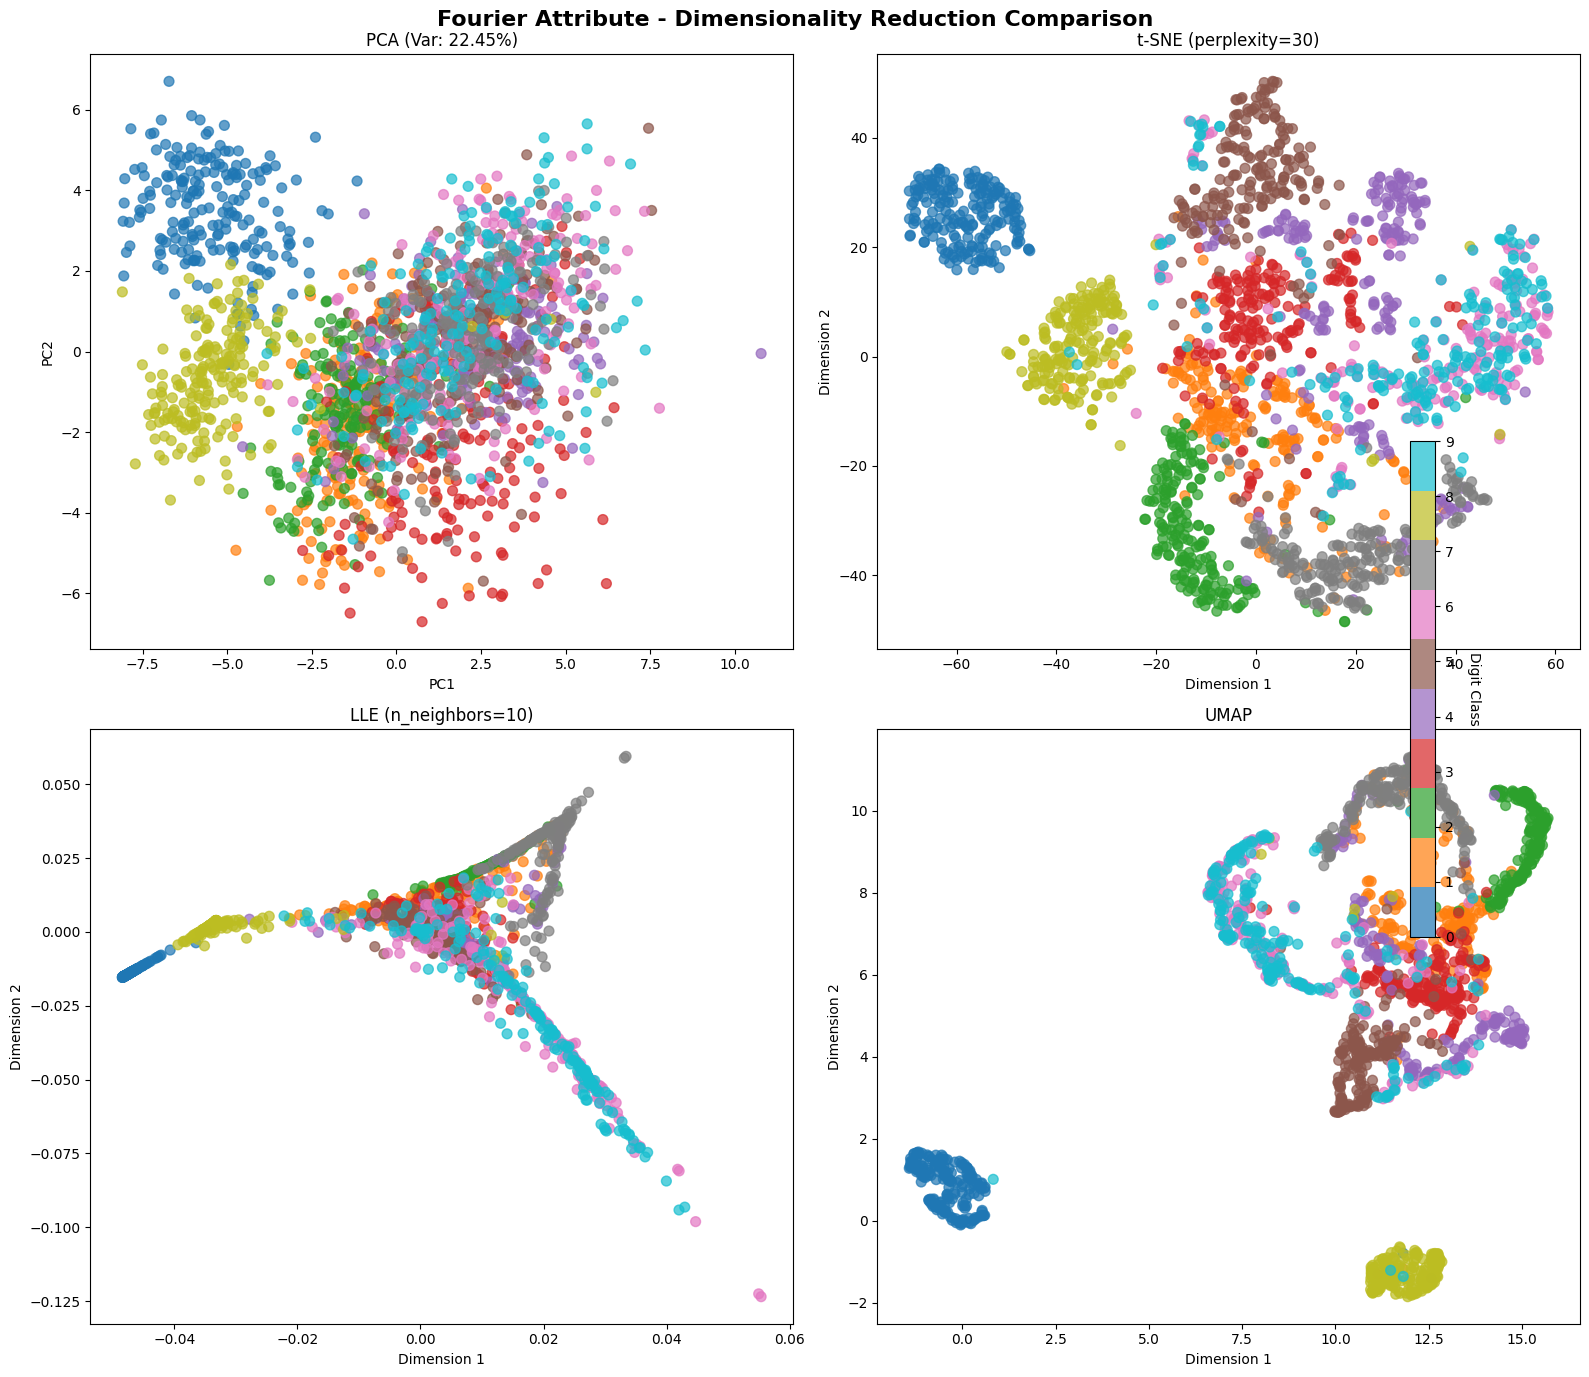


Profile: 2000 samples
Running PCA for Profile...
Running t-SNE for Profile (perplexity=30)...
Running LLE for Profile (n_neighbors=10)...
Running UMAP for Profile...


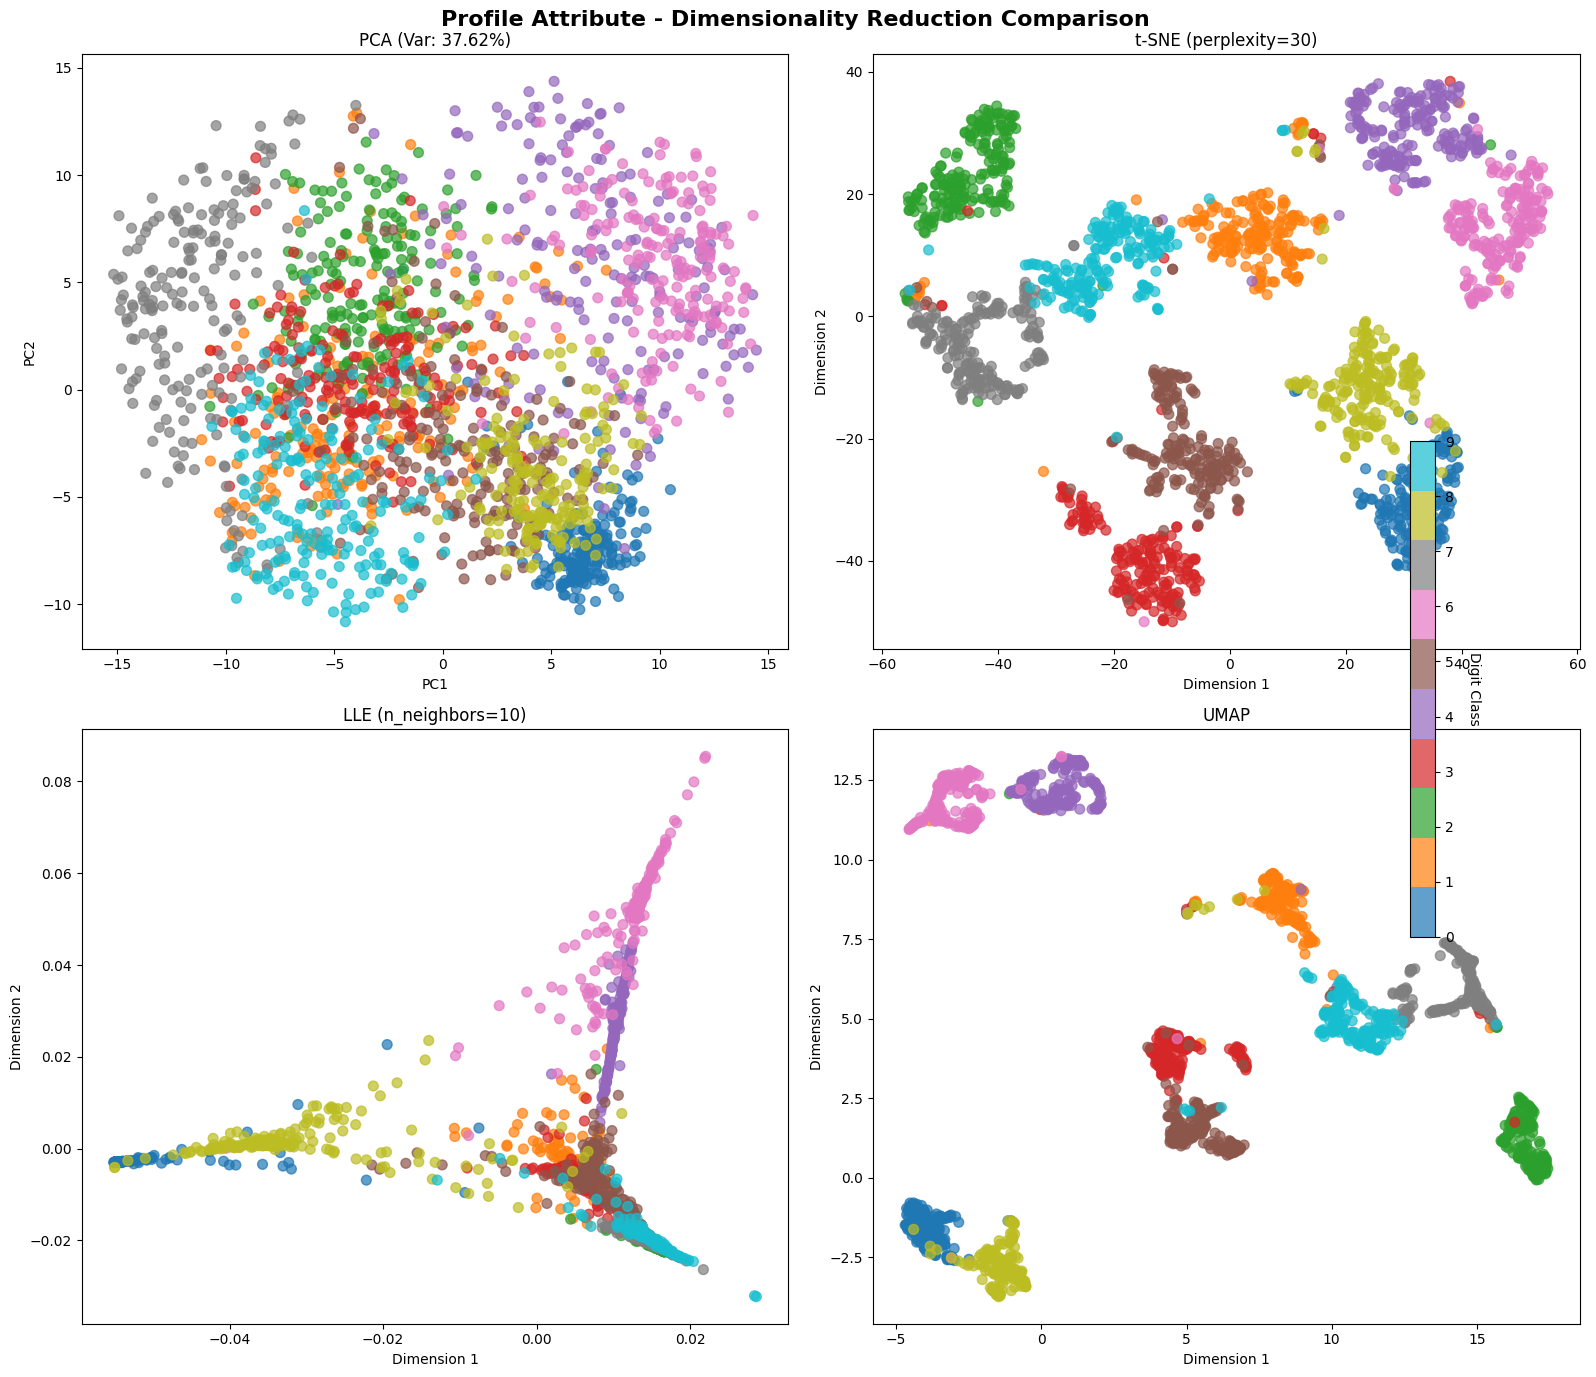


Karhunen-Loeve: 2000 samples
Running PCA for Karhunen-Loeve...
Running t-SNE for Karhunen-Loeve (perplexity=30)...
Running LLE for Karhunen-Loeve (n_neighbors=10)...
Running UMAP for Karhunen-Loeve...


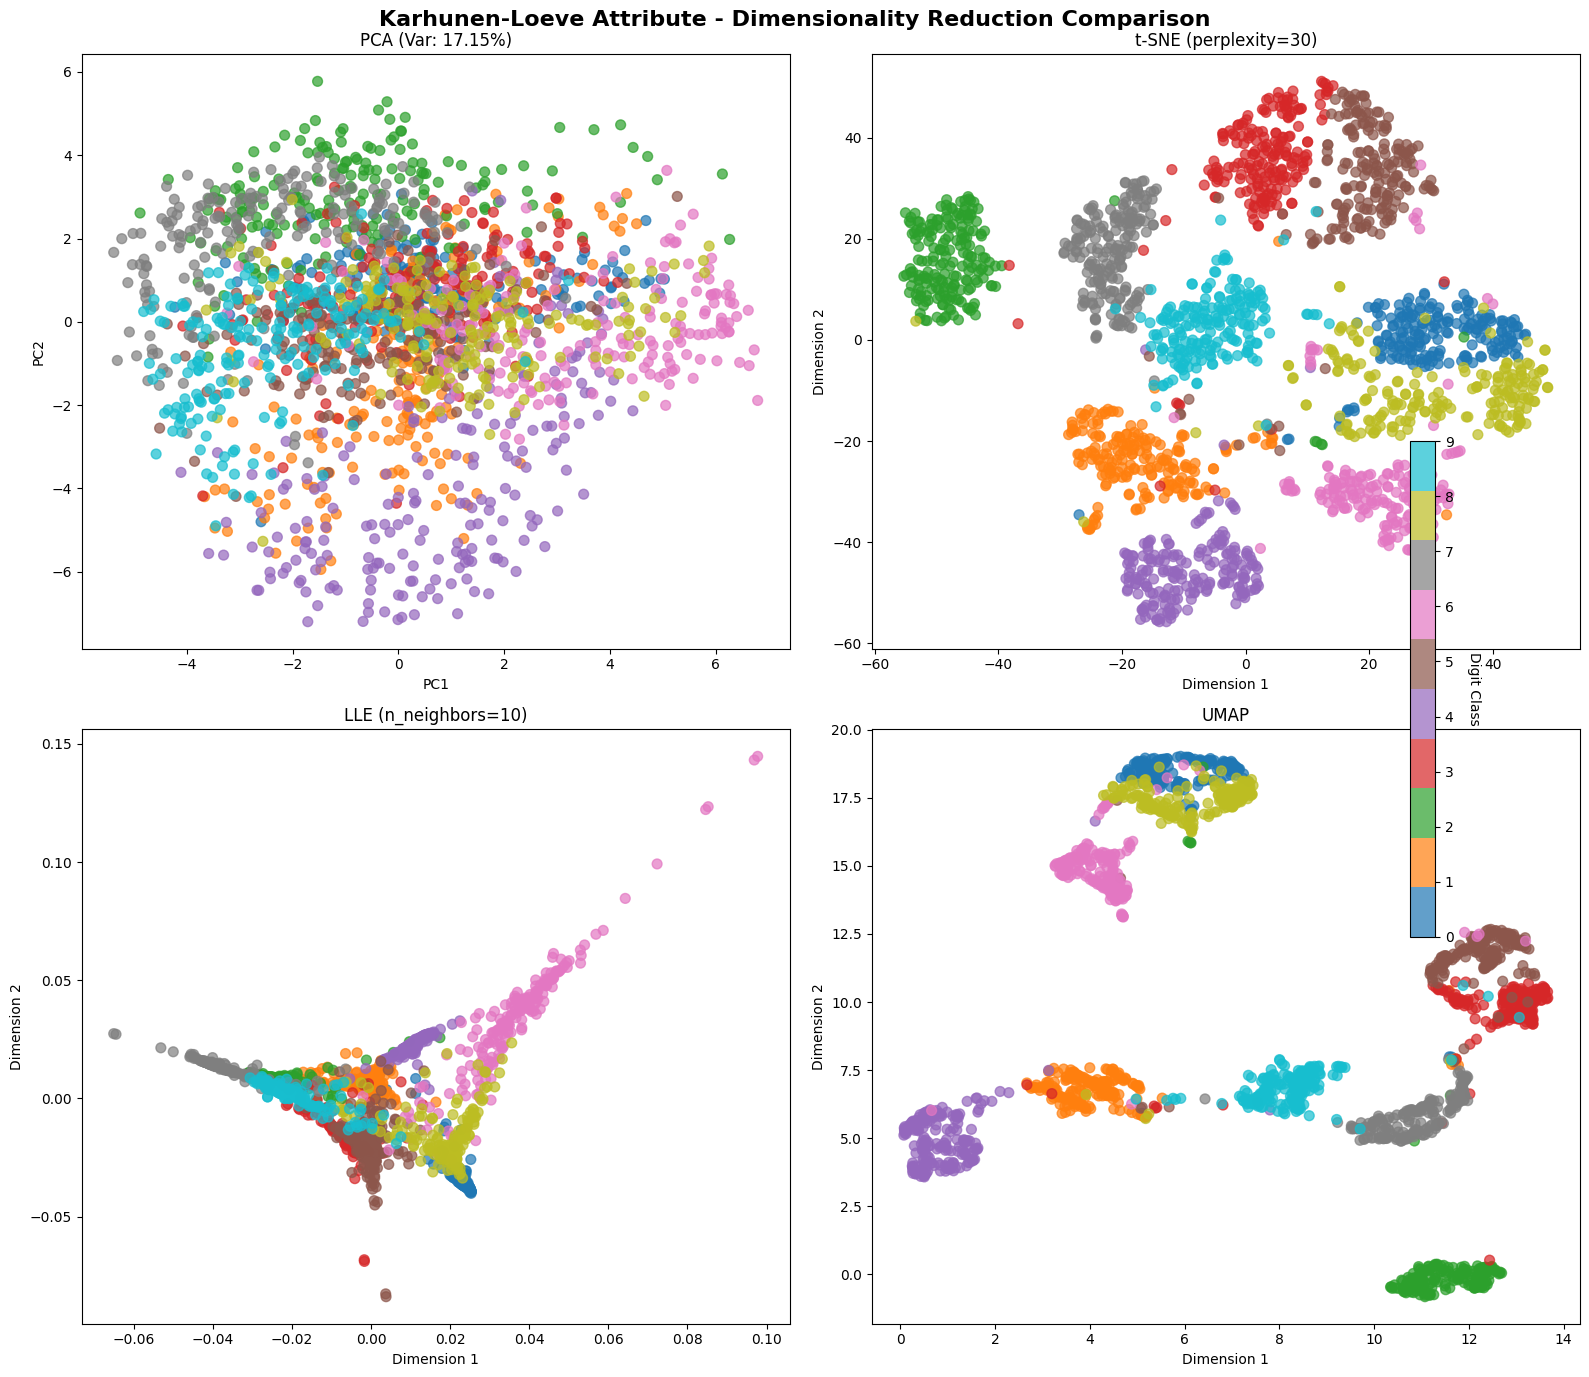


Pixels: 2000 samples
Running PCA for Pixels...
Running t-SNE for Pixels (perplexity=30)...
Running LLE for Pixels (n_neighbors=10)...
Running UMAP for Pixels...


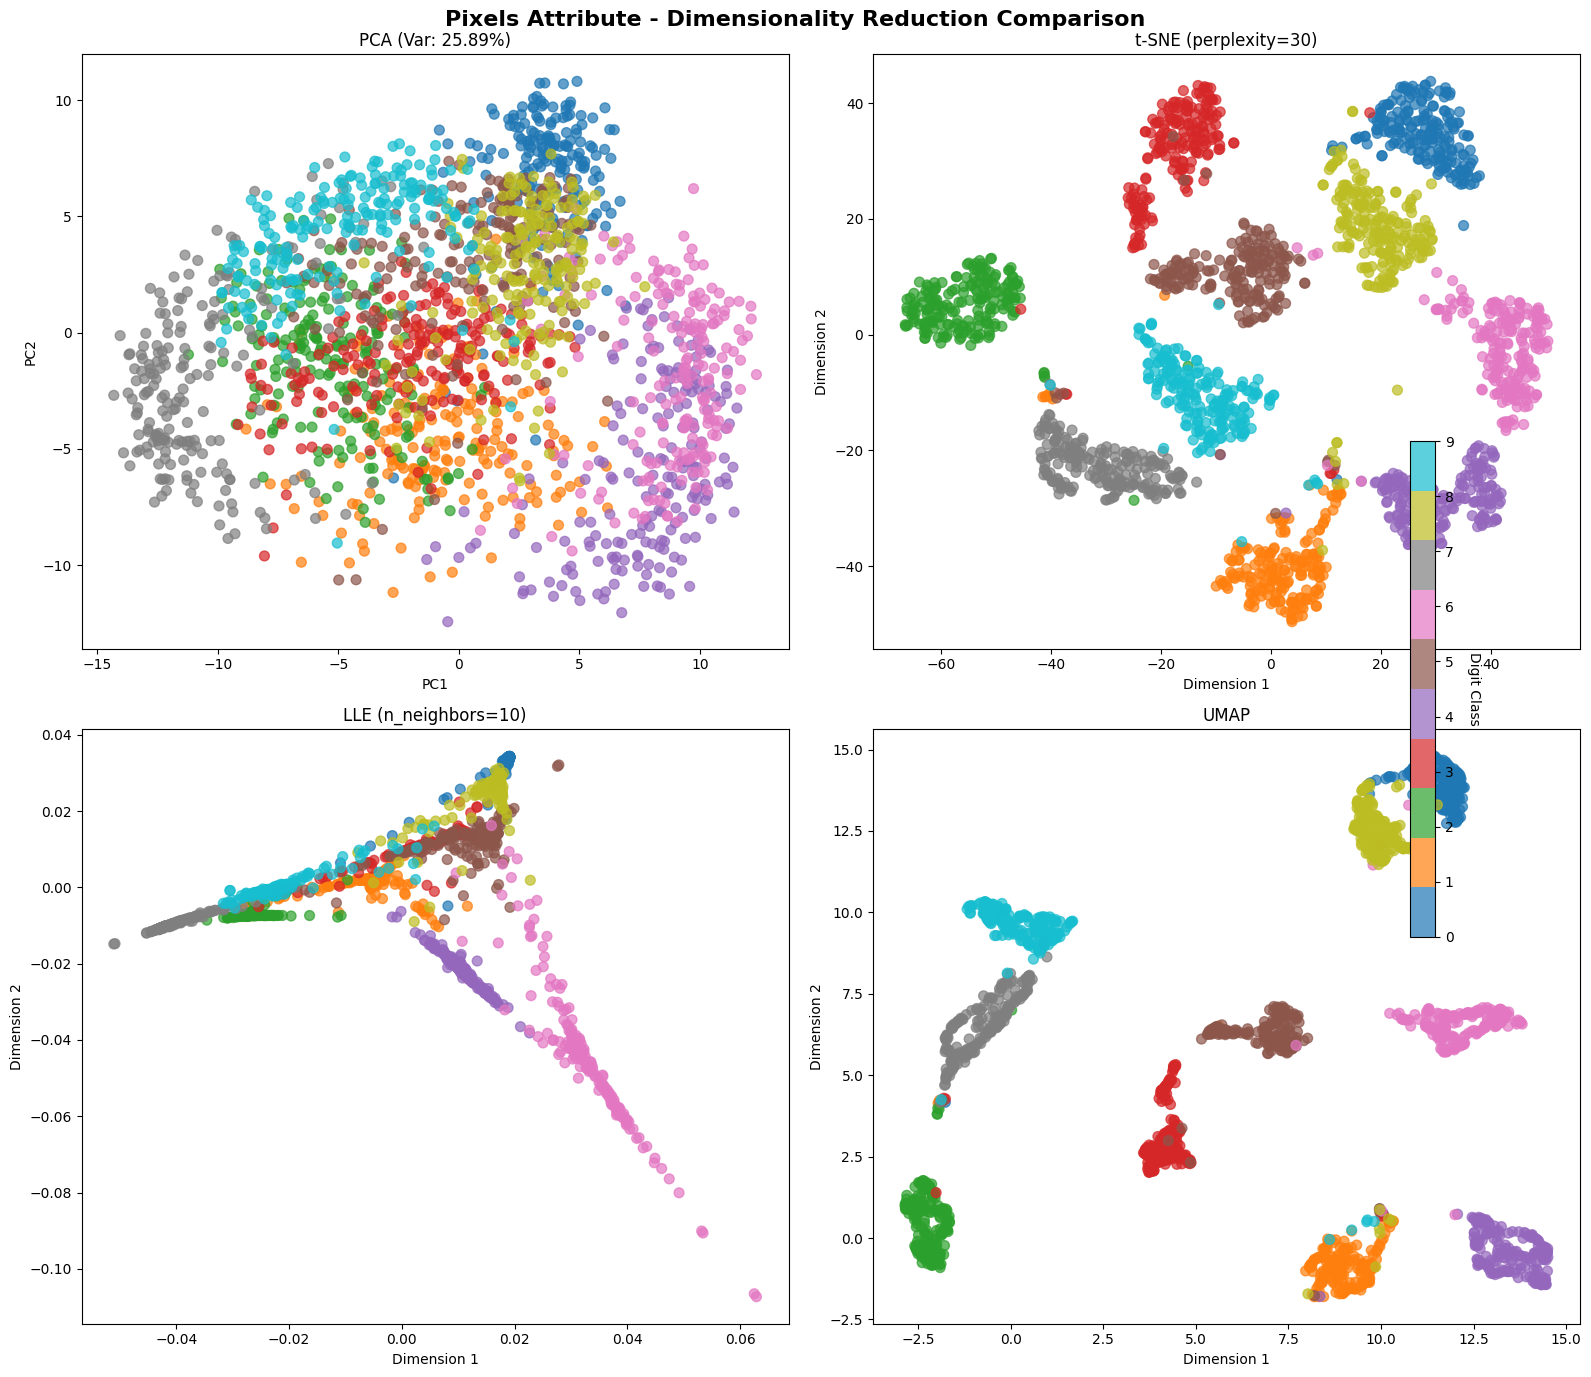


Zernike: 2000 samples
Running PCA for Zernike...
Running t-SNE for Zernike (perplexity=30)...
Running LLE for Zernike (n_neighbors=10)...
Running UMAP for Zernike...


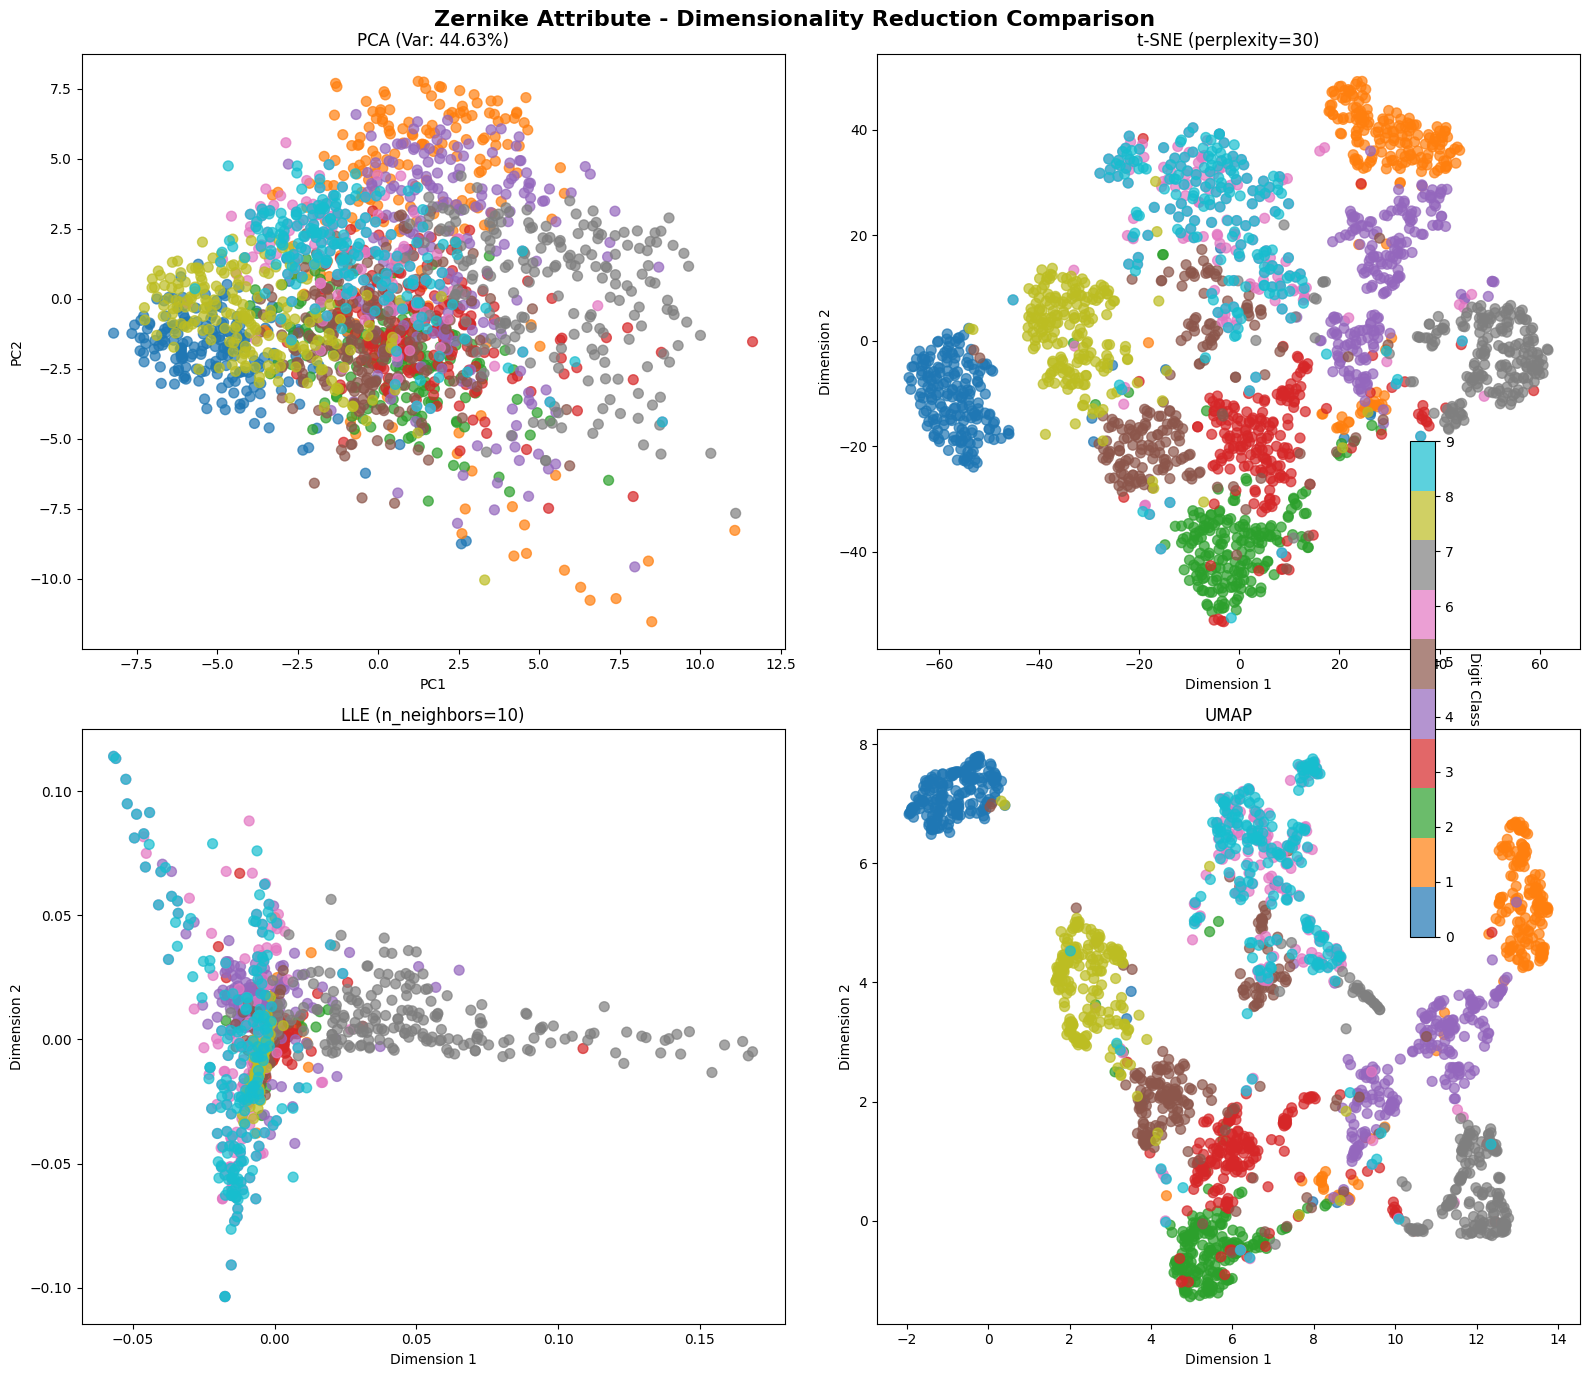

In [16]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from umap import UMAP

def plot_dimensionality_reduction(data, labels, condition_name):

    # Define the 10 class names
    class_names = ['0','1','2','3','4','5','6','7', '8', '9']

    n_samples = data.shape[0]
    print(f"\n{condition_name}: {n_samples} samples")

    # Adjust parameters based on sample size
    perplexity = min(30, n_samples - 1)  # t-SNE perplexity must be < n_samples
    n_neighbors = min(10, n_samples - 1)  # LLE n_neighbors must be < n_samples

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'{condition_name} Attribute - Dimensionality Reduction Comparison',
                 fontsize=16, fontweight='bold')

    # 1. PCA
    print(f"Running PCA for {condition_name}...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    scatter1 = axes[0, 0].scatter(pca_result[:, 0], pca_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 0].set_title(f'PCA (Var: {pca.explained_variance_ratio_.sum():.2%})')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')

    # 2. t-SNE
    print(f"Running t-SNE for {condition_name} (perplexity={perplexity})...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result = tsne.fit_transform(data)

    scatter2 = axes[0, 1].scatter(tsne_result[:, 0], tsne_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 1].set_title(f't-SNE (perplexity={perplexity})')
    axes[0, 1].set_xlabel('Dimension 1')
    axes[0, 1].set_ylabel('Dimension 2')

    # 3. LLE
    print(f"Running LLE for {condition_name} (n_neighbors={n_neighbors})...")
    lle = LocallyLinearEmbedding(
        n_components=2,
        random_state=42,
        n_neighbors=n_neighbors
    )
    lle_result = lle.fit_transform(data)

    scatter3 = axes[1, 0].scatter(lle_result[:, 0], lle_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[1, 0].set_title(f'LLE (n_neighbors={n_neighbors})')
    axes[1, 0].set_xlabel('Dimension 1')
    axes[1, 0].set_ylabel('Dimension 2')

    # 4. UMAP
    print(f"Running UMAP for {condition_name}...")
    umap_model = UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=min(15, n_samples - 1)
    )
    umap_result = umap_model.fit_transform(data)

    scatter4 = axes[1, 1].scatter(umap_result[:, 0], umap_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[1, 1].set_title('UMAP')
    axes[1, 1].set_xlabel('Dimension 1')
    axes[1, 1].set_ylabel('Dimension 2')

    # Add a shared colorbar
    cbar = plt.colorbar(scatter4, ax=axes, orientation='vertical',
                       fraction=0.02, pad=0.04)
    cbar.set_label('Digit Class', rotation=270, labelpad=20)
    cbar.set_ticks(range(10))
    cbar.set_ticklabels(class_names)

    plt.tight_layout()
    plt.show()

# Example usage for each condition:
conditions = ['Fourier', 'Profile', 'Karhunen-Loeve', 'Pixels', 'Zernike']
datasets = [fou_scaled,
            fac_scaled,
            kar_scaled,
            pix_scaled,
            zer_scaled
]
labels_list = [fou_labels,
               fac_labels,
               kar_labels,
               pix_labels,
               zer_labels
]

# Check sample sizes before plotting
for condition, data, labels in zip(conditions, datasets, labels_list):
    print(
        f"{condition}: "
        f"{data.shape[0]} samples, "
        f"{len(np.unique(labels))} unique labels"
    )

# Now plot
for condition, data, labels in zip(conditions, datasets, labels_list):
    plot_dimensionality_reduction(data, labels, condition)

Our results are strikingly clear! Notice the UMAP plot for Pixels. These clusters are noticeably more dramatic than any the other UMAP plots for the 4 other attributes.

#4. A) K-means Clustering

Cluster the images in each condition using K-Means (apply K-means separately to images from each folder)


To make the process faster, reduce the dimensionality using PCA, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class, suitable for the K-means algorithm.

>Silhouette score is our chosen way of calculating the "optimal" number of clusters. Implementing it is relatively simple thanks to sklearn's silhouette_score() function. Individual silhouette coefficients are calculated for each image after clustering, with instances that are more nested within their own clusters receiving higher coefficients. The silhouette score is just the mean of all silhouette coefficients, so a higher score is also better. Because of that, once we've calculated all the different silhouette scores for different numbers of clusters (within a reasonable range -- we test from 2 to 11 clusters), we can just use argmax() to find the best value of k for each folder.

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

results = {}

pcaED_data = defaultdict(list)   # datasets but now they all have the pca

for condition, data, labels in zip(conditions, datasets, labels_list):

    print(f"{condition}")

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95, svd_solver='full')
    data_pca = pca.fit_transform(data)
    pcaED_data[condition].append(data_pca)

    print(f"Original dim: {data.shape[1]}, PCA dim: {data_pca.shape[1]}")

    # Determine number of clusters (silhouette)
    k_values = range(2, 11)
    sil_scores = []

    for k in k_values:
        kmeans_temp = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans_temp.fit_predict(data_pca)
        score = silhouette_score(data_pca, cluster_labels)
        sil_scores.append(score)

    best_k = k_values[np.argmax(sil_scores)]
    print(f"Best k (silhouette): {best_k}")

    # Fit final K-means with best k
    kmeans_final = KMeans(n_clusters=best_k, random_state=42)
    final_labels = kmeans_final.fit_predict(data_pca)

    # Store results for later usage
    results[condition] = {
        "pca_components": data_pca,
        "n_components": data_pca.shape[1],
        "best_k": best_k,
        "cluster_labels": final_labels,
        "silhouette_scores": sil_scores
    }
    print()


print("\nFinished clustering all conditions")

Fourier
Original dim: 76, PCA dim: 58
Best k (silhouette): 2

Profile
Original dim: 216, PCA dim: 30
Best k (silhouette): 9

Karhunen-Loeve
Original dim: 64, PCA dim: 50
Best k (silhouette): 8

Pixels
Original dim: 240, PCA dim: 91
Best k (silhouette): 10

Zernike
Original dim: 47, PCA dim: 16
Best k (silhouette): 7


Finished clustering all conditions


The cluster counts (Best K) appear to be *very* low for Fourier. Remember that we should actually have 10 clusters, but for Fourier we have only 2! Pixels performed remarkably at 10 clusters. Profile and Karhunen-Loeve weren't far behind at 9 and 8 respectively.

#4. B) Manually Setting 10 Clusters

Set the number of clusters to 10 (ground truth), report clustering accuracy (choose an appropriate mapping) and show a confusion matrix.

>For our clustering accuracy, using the actual accuracy score isn't generally advised for k-means clustering. Because it's an unsupervised process that doesn't use labeling, it doesn't really make sense to compare it to labels that we assign to our items without actually feeding them into our model. Oftentimes, a different metric is better, such as the silhouette score used in part 4A. Below, silhouette score is calculated for each condition with k = 10 clusters.

>However, for the purposes of this problem (and generally in situations where we know how each item *should* be clustered), we can still assign labels. We already assigned each image a "truth" label from 0 to 9 based on what it portrays, so we can compare these to the "predictive" labels generated by the K-means clustering. It's very unlikely that the truth label and predictive label numbers correspond to the same categories, so our mapping should try to align them. The label numbers don't change with this code, but they are matched as desired. From there, we can compute our confusion matrix for each condition.

In [18]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns

print("Silhouette scores for k = 10 clusters:")

for condition, data, labels in zip(conditions, datasets, labels_list):
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95, svd_solver='full')
    data_pca = pca.fit_transform(data)
    pcaED_data[condition].append(data_pca)

    # Fit K-Means with k = 10
    kmeans = KMeans(n_clusters = 10, random_state = 42)
    cluster_labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, cluster_labels)
    print(f"{condition}: silhouette = {score:.4f}")

Silhouette scores for k = 10 clusters:
Fourier: silhouette = 0.0746
Profile: silhouette = 0.1924
Karhunen-Loeve: silhouette = 0.0836
Pixels: silhouette = 0.1258
Zernike: silhouette = 0.1679


Accuracy for Fourier: 0.5910


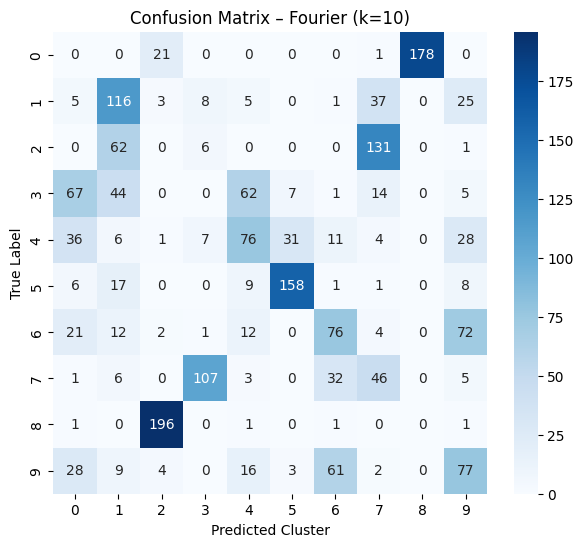

Accuracy for Profile: 0.7740


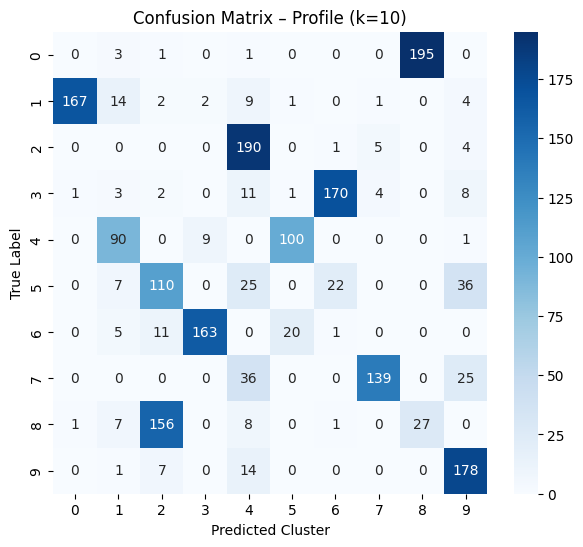

Accuracy for Karhunen-Loeve: 0.6770


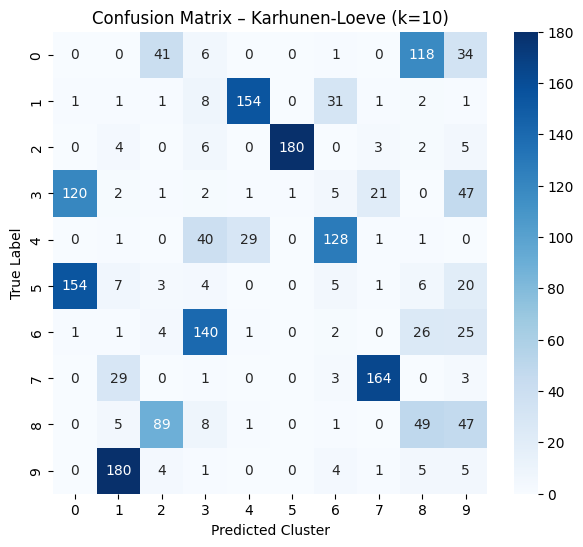

Accuracy for Pixels: 0.7055


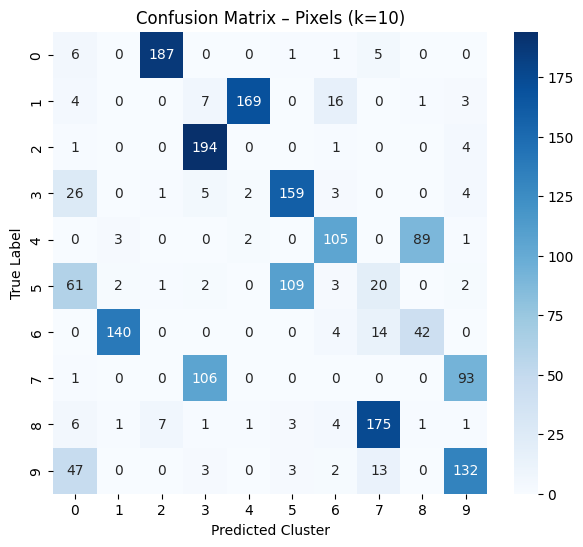

Accuracy for Zernike: 0.4845


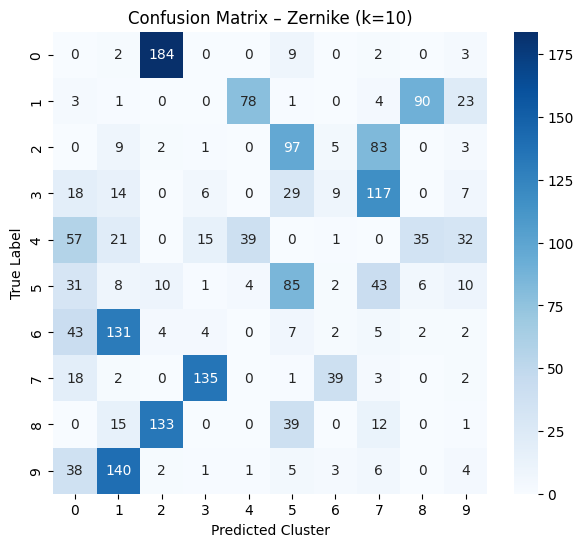

In [19]:
for condition, data, labels in zip(conditions, datasets, labels_list):
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95, svd_solver='full')
    data_pca = pca.fit_transform(data)
    pcaED_data[condition].append(data_pca)

    # Fit K-Means with k = 10
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(data_pca)

    # Mapping to try and match truth and predictive labels
    k_labels = kmeans.labels_
    k_labels_matched = np.empty_like(k_labels)

    for k in np.unique(k_labels):
        match_nums = [
            np.sum((k_labels == k) * (labels == t))
            for t in np.unique(labels)
        ]
        k_labels_matched[k_labels == k] = np.unique(labels)[np.argmax(match_nums)]

    # Compute accuracy score between truth and predictive labels
    accuracy = np.mean(labels == k_labels_matched)
    print(f"Accuracy for {condition}: {accuracy:.4f}")

    # Calculate confusion matrix (true vs raw cluster labels)
    cm = confusion_matrix(labels, k_labels)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {condition} (k=10)")
    plt.xlabel("Predicted Cluster")
    plt.ylabel("True Label")
    plt.show()

Profile has the highest accuracy at 77%. Zernike has the lowest at 48%.

#5. A) EM (Expectation-Maximization)

Cluster each condition using EM.


Reduce again the dimensionality using PCA, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class, suitable for the EM algorithm.

>In this step, we reduced the dimensionality of the data with PCA while keeping 95% of the variance. Then we fit a Gaussian Mixture Model to cluster the images into 8 groups. This creates a low-dimensional representation that the EM algorithm can model more effectively.

In [20]:
from sklearn.mixture import GaussianMixture

conditions = ['Fourier', 'Profile', 'Karhunen-Loeve', 'Pixels', 'Zernike']
datasets = [
    mfeat_fou,
    mfeat_fac,
    mfeat_kar,
    mfeat_pix,
    mfeat_zer
]
gmm_results = {}

for name, data in zip(conditions, datasets):

    # PCA (95%), then fit GMM with one component per true class
    scaler = StandardScaler().fit(data)
    data_scaled = scaler.transform(data)

    pca = PCA(n_components=0.95, svd_solver='full')
    data_p = pca.fit_transform(data_scaled)

    n_classes = len(np.unique(labels))
    gmm = GaussianMixture(
        n_components=n_classes,
        covariance_type='full',
        random_state=42
    ).fit(data_p)

    gmm_results[name] = {
        'scaler': scaler,
        'pca': pca,
        'gmm': gmm,
        'data_p': data_p
    }

    print(
        name,
        '-> PCA dims:', data_p.shape[1],
        ' GMM converged:', gmm.converged_
    )

Fourier -> PCA dims: 58  GMM converged: True
Profile -> PCA dims: 30  GMM converged: True
Karhunen-Loeve -> PCA dims: 50  GMM converged: True
Pixels -> PCA dims: 91  GMM converged: True
Zernike -> PCA dims: 16  GMM converged: True


The PCA results show how many dimensions were needed to capture 95% of the variance, and the Gaussian Mixture Model output indicates how the data was grouped into 10 clusters. These cluster sizes help us see whether certain digit classes are easier or harder for the model to separate in each individual attribute condition.

#5. B)  Manually Setting 10 Clusters (EM)

Set the number of clusters to 10 (ground truth), report clustering accuracy (choose an appropriate mapping) and show a confusion matrix.

> Using the GMM cluster assignments, we mapped each cluster to the true category it contained most often (simple majority-vote rule). This allowed us to compute accuracy and plot confusion matrices that show how well the unsupervised EM clustering recovered the 10 categories. Clearer diagonal patterns indicate that the GMM captured meaningful structure in that visual condition.

In [21]:
# majority vote
from sklearn.metrics import accuracy_score
from collections import Counter

labels_list = [
    fou_labels,
    fac_labels,
    kar_labels,
    pix_labels,
    zer_labels
]

def map_clusters_majority(y_true, y_pred, n_classes=10):

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    mapping = {}

    # For each cluster (column), find the true label with highest count (mode)
    for cluster_id in range(cm.shape[1]):

        # find row index (true label) with max count for this cluster
        col_counts = cm[:, cluster_id]
        if col_counts.sum() == 0:
            mapping[cluster_id] = cluster_id
        else:
            mapped_label = int(np.argmax(col_counts))
            mapping[cluster_id] = mapped_label

    # apply mapping
    y_pred_mapped = np.array([mapping.get(c, c) for c in y_pred], dtype=int)
    return y_pred_mapped, cm

Fourier accuracy (majority-mapped) = 0.604


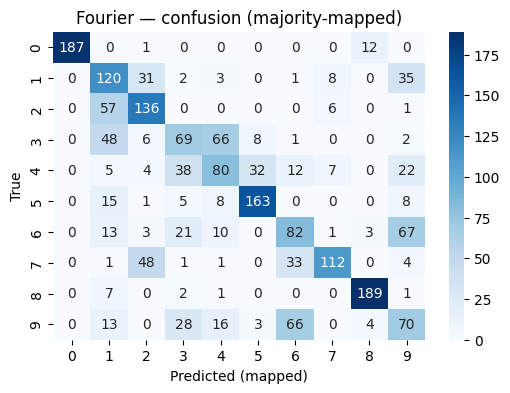

Profile accuracy (majority-mapped) = 0.818


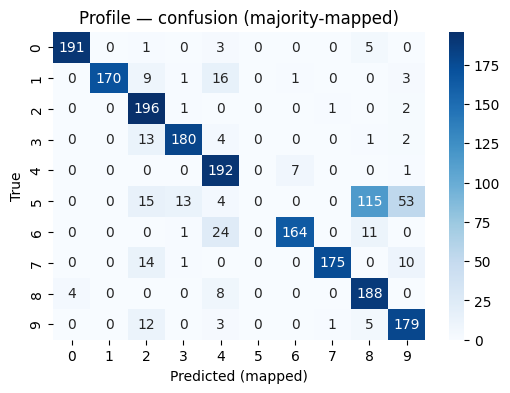

Karhunen-Loeve accuracy (majority-mapped) = 0.705


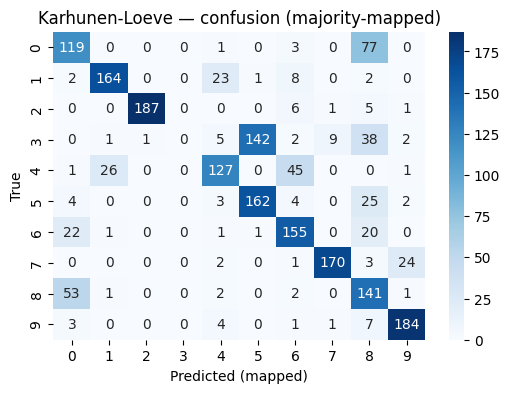

Pixels accuracy (majority-mapped) = 0.706


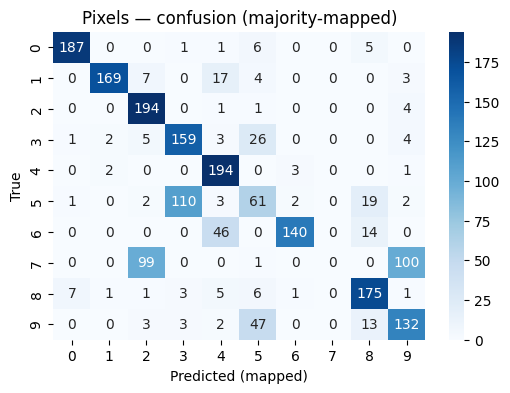

Zernike accuracy (majority-mapped) = 0.515


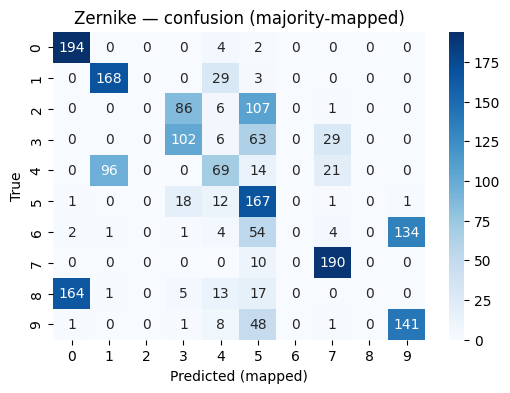

In [22]:
for name, data, y_true in zip(conditions, datasets, labels_list):
    info = gmm_results[name]

    # predict using the GMM in PCA
    y_pred = info['gmm'].predict(
        info['pca'].transform(
            info['scaler'].transform(data)
        )
    )

    # Map cluster IDs: true labels by majority vote
    y_pred_mapped, raw_cm = map_clusters_majority(y_true, y_pred, n_classes=10)

    # compute accuracy
    acc = accuracy_score(y_true, y_pred_mapped)
    print(f"{name} accuracy (majority-mapped) = {acc:.3f}")

    # plot confusion matrix: true vs. mapped-predicted
    plt.figure(figsize=(6,4))
    sns.heatmap(
        confusion_matrix(y_true, y_pred_mapped),
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title(f"{name} — confusion (majority-mapped)")
    plt.xlabel("Predicted (mapped)"); plt.ylabel("True")
    plt.show()

After mapping clusters to true labels, the confusion matrices show how well the GMM clusters align with the 10 true categories: a strong diagonal and high accuracy indicate the EM algorithm recovered the underlying object classes, while large off-diagonal blocks reveal confusion between categories. Profile appears to have the strongest alignment with the true categories (82%). Zernike appears to be the worst performing (52%).

#5. C) 5 New Images
Use the model to generate 5 new images for each condition (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).

> Using the trained GMMs, we sample new synthetic points in PCA space and invert the PCA and scaling steps to reconstruct them as images. These generated images will show what the model thinks each visual condition looks like.

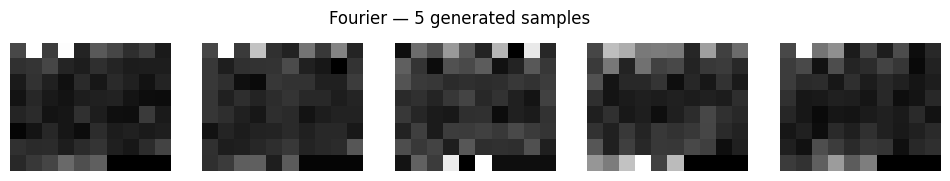

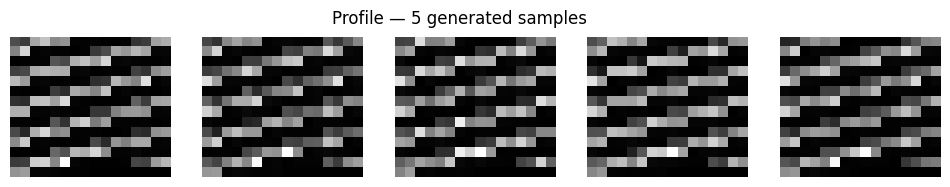

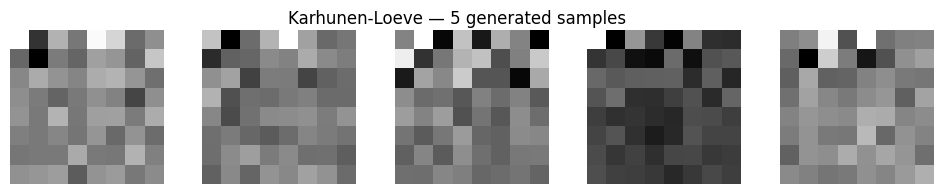

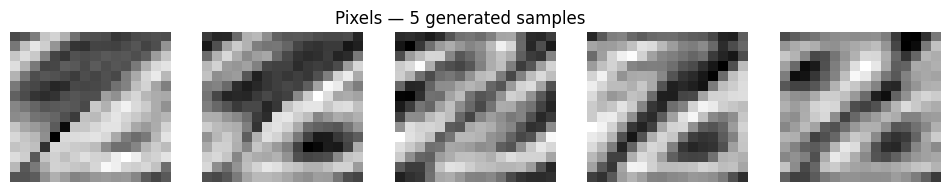

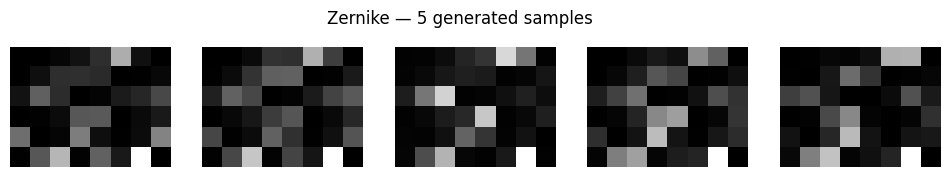

In [23]:
n_generate = 5

for name in conditions:
    info = gmm_results[name]
    samples_pca, _ = info['gmm'].sample(n_generate)
    samples_scaled = info['pca'].inverse_transform(samples_pca)
    samples_raw = info['scaler'].inverse_transform(samples_scaled)

    plt.figure(figsize=(12, 2))
    for i, s in enumerate(samples_raw):
        # Visualize each generated sample
        img = vector_to_image(s)
        plt.subplot(1, n_generate, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle(f"{name} — {n_generate} generated samples")
    plt.show()

The generated images visualize what the model learned about each attribute condition. Keep in mind that our original data was not the written images of digits-- it was the compressed metadata that could numerically represent properties about the written image. We knew from the start that "Pixels" was the only attribute that would allow us to accurately recreate the original handwritten source material. It was the only attribute we knew we could derive a solid numerical representation from (and we saw this in Part 2). I'm satisfied with our result because it shows 5 incredibly distinct attributes with different textures and complexity. This is satisfactory given the nature of our beginning information (compressed metadata that could numerically represent properties about the written image).

#5. D) ResNet Model

Repeat Part 5B, but instead of features derived using PCA, use features obtained with a pretrained ResNet model.

> Instead of PCA, we'll extracted features using a pretrained ResNet model and then cluster those features with a GMM the same way as before. This tests whether deeper, learned features improve clustering accuracy compared to PCA features.

In [24]:
import torch
import torch.nn as nn
from torchvision import models, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained resnet18
try:
    resnet = models.resnet18(pretrained=True)
except Exception:
    resnet = models.resnet18(pretrained=False)
backbone = nn.Sequential(*list(resnet.children())[:-1]).to(device)
backbone.eval()

def extract_features_from_flatbatch(flat_arrs, img_h=64, img_w=64):
    flat_arrs = np.asarray(flat_arrs)
    n, d = flat_arrs.shape
    target_dim = img_h * img_w

    # pad or truncate to match 64x64
    if d != target_dim:
        Xp = np.zeros((n, target_dim), dtype=flat_arrs.dtype)
        if d >= target_dim:
            Xp[:, :] = flat_arrs[:, :target_dim]
        else:
            Xp[:, :d] = flat_arrs
        flat_arrs = Xp

    tensors = []
    for arr in flat_arrs:
        img = arr.reshape(img_h, img_w).astype('float32')
        # normalize to [0,1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img_rgb = np.stack([img] * 3, axis=2)  # duplicate channels
        t = transforms.ToTensor()(img_rgb).unsqueeze(0)  # [1,3,H,W]
        t = transforms.functional.resize(t, (224, 224))   # to ResNet input
        tensors.append(t.squeeze(0))

    X = torch.stack(tensors).to(device)
    with torch.no_grad():
        feats = backbone(X).view(X.size(0), -1).cpu().numpy()
    return feats

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


Fourier ResNet-GMM accuracy (majority-mapped) = 0.393


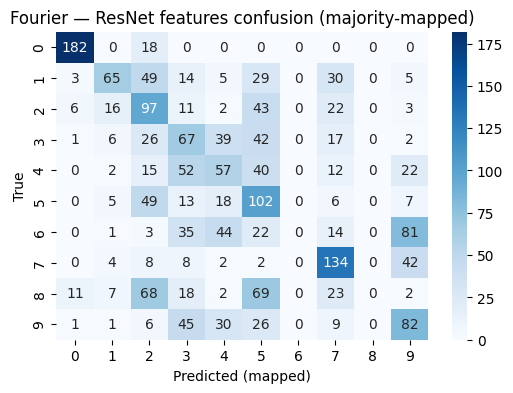

Profile ResNet-GMM accuracy (majority-mapped) = 0.525


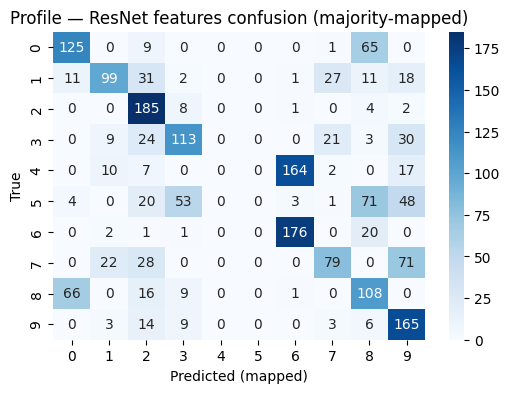

Karhunen-Loeve ResNet-GMM accuracy (majority-mapped) = 0.360


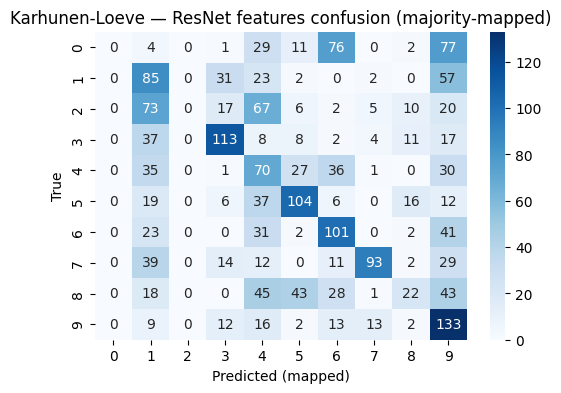

Pixels ResNet-GMM accuracy (majority-mapped) = 0.377


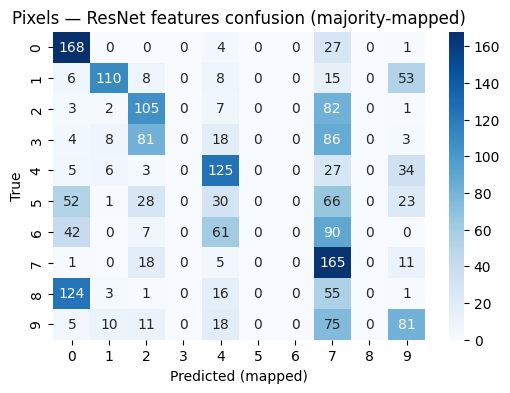

Zernike ResNet-GMM accuracy (majority-mapped) = 0.457


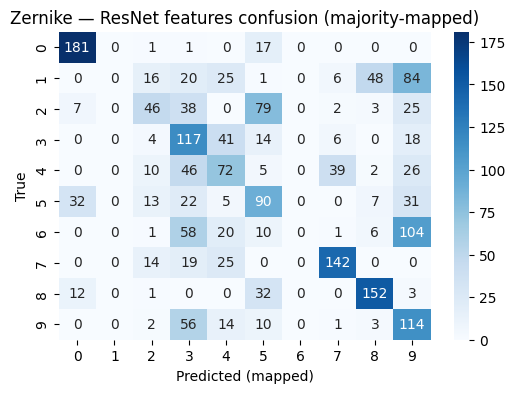

In [25]:
for name, data, y_true in zip(conditions, datasets, labels_list):
    feats = extract_features_from_flatbatch(data)              # (n, 512)
    feats_s = StandardScaler().fit_transform(feats)
    n_classes = len(np.unique(y_true))

    gmm = GaussianMixture(
        n_components=n_classes,
        covariance_type='full',
        random_state=42
    ).fit(feats_s)

    y_pred = gmm.predict(feats_s)

    # Map & evaluate
    y_pred_mapped, raw_cm = map_clusters_majority(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred_mapped)
    print(f"{name} ResNet-GMM accuracy (majority-mapped) = {acc:.3f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix(y_true, y_pred_mapped),
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title(f"{name} — ResNet features confusion (majority-mapped)")
    plt.xlabel('Predicted (mapped)')
    plt.ylabel('True')
    plt.show()

Using ResNet features generally produces higher accuracy and clearer confusion matrices, showing that deep neural network features separate the categories more effectively than PCA features. Comparing these confusion matrices and accuracies to Part 5B, we're seeing no improvements. In this model, we're seeing worse accuracies and poorer diagonals across the board.